It's almost always convenient to use transfer learning. Research papers raccomend it whenever possible.

Where to find trained models:
- PyTorch domain libraries (torchvision, torchtext, torchaudio, torchrec)
- HuggingFace Hub
- PyTorch Image Models library (timm)
- Paperswithcode

In [1]:
import torch
import torchvision
from torch import nn
from torchinfo import summary
from torchvision import transforms

import sys
from PIL import Image
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt

from modules import data_setup, engine

/home/glauco/Desktop/projects/learningPyTorch/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
venv_dir = Path(sys.prefix)
project_root = venv_dir.parent
data_path = project_root/"data"
test_dir = data_path/"pizza_steak_sushi"/"test"
train_dir = data_path/"pizza_steak_sushi"/"train"

# When using transfer learning, it's imperative that the custom data is prepared in the same way as the data used to train the model originally
# Prior to torchvision v0.13+, the documentation stated:
# "All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
# The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]". Dimensions could vary (224, 240, ...)
# Mean and std came from the ImageNet database. The model can learn them on his now but it will be faster this way

# MANUALLY created transform:
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),            # Normalizes image values from 0-255 to 0-1 and reshapes HxWxC to CxHxW
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# As of torchvision v0.13+, an automatic transform creation feature has been added
# The higher the number, the bigger the model, the better the performance
# But there is a speed vs size vs performance tradeoff, and some models are just too big for some devices
# DEFAULT means the best available weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Now we can automatically access the transform used on the data that was used to train the model
# This lacks customization but it ensures we have the right transform
auto_transform = weights.transforms()
print(auto_transform)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=32
)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [4]:
# EfficientNet_B0, from paper "https://arxiv.org/abs/1905.11946", achieves ~77.7% accuracy across ImageNet's 1000 classes
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# The model has three parts:
# - features: a bunch of convolutional layers and activation layers to learn the image features
# - avgpool: for every feature, turns the 7x7 to a 1x1, creating a feature vector
# - classifier: turns the 1280 long feature vector into a 1000 long vector representing the output classes
print(model)
print(summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
# Changing the classifier and freezing some base layers

# Freezing the parameters of the features block
for param in model.features.parameters():
    param.requires_grad = False

output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),                                                  # Keeping the dropout layer
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True).to(device)      # Modifying the linear layer for our problem
)

# From 5.288.548 trainable parameters to 3.843 (less then TinyVGG)
print(summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
from timeit import default_timer as timer

start_time = timer()
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device
)
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:05<00:20,  5.06s/it]

Epoch: 1 | train_loss: 0.5897 | train_acc: 0.7734 | test_loss: 0.5805 | test_acc: 0.8352


 40%|████      | 2/5 [00:09<00:14,  4.84s/it]

Epoch: 2 | train_loss: 0.5293 | train_acc: 0.8086 | test_loss: 0.5449 | test_acc: 0.8049


 60%|██████    | 3/5 [00:14<00:09,  4.80s/it]

Epoch: 3 | train_loss: 0.5383 | train_acc: 0.8125 | test_loss: 0.5172 | test_acc: 0.8561


 80%|████████  | 4/5 [00:19<00:04,  4.95s/it]

Epoch: 4 | train_loss: 0.4887 | train_acc: 0.8164 | test_loss: 0.4396 | test_acc: 0.8665


100%|██████████| 5/5 [00:24<00:00,  4.98s/it]

Epoch: 5 | train_loss: 0.4758 | train_acc: 0.7969 | test_loss: 0.4280 | test_acc: 0.8561
Total training time: 24.905 seconds


In [12]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: Path,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device=device
):
    img = Image.open(image_path)

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = transform(img).unsqueeze(dim=0).to(device)
        target_pred = model(transformed_image)
    
    target_pred_probs = torch.softmax(target_pred, dim=1)
    target_pred_labels = torch.argmax(target_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Model predicts '{class_names[target_pred_labels]}' with {target_pred_probs.max()*100:.1f}% probability")
    plt.axis(False)

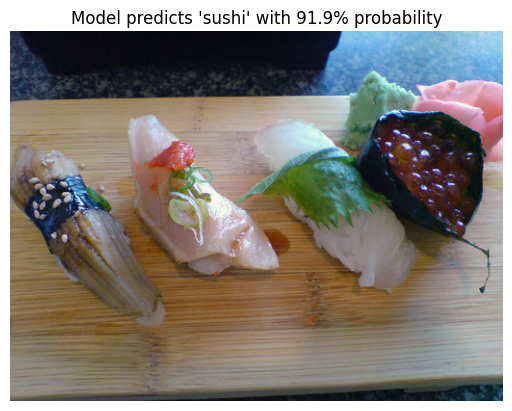

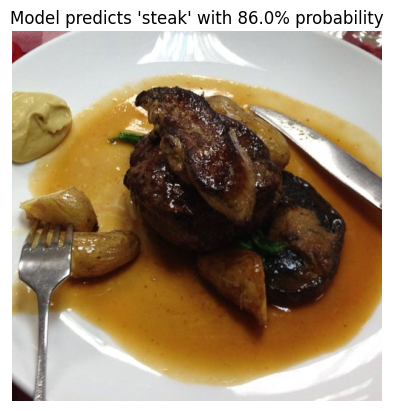

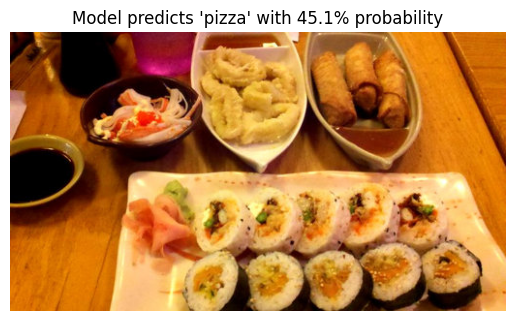

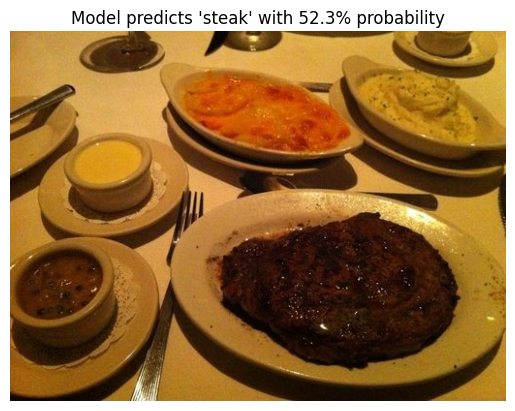

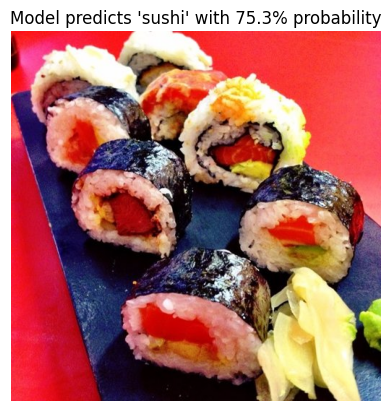

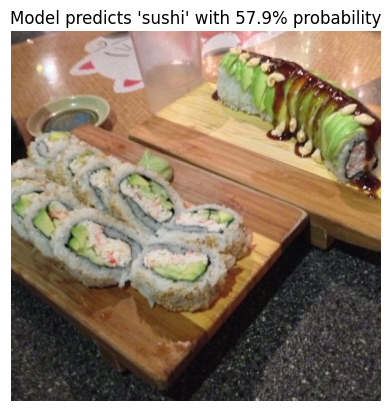

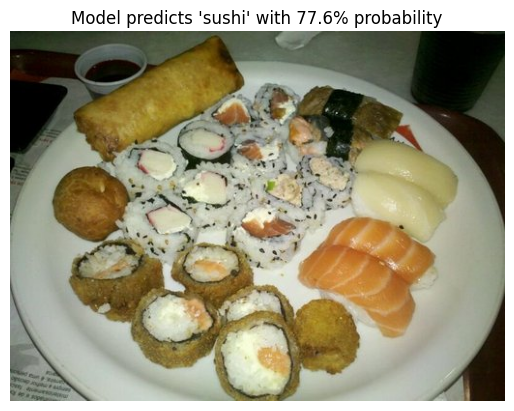

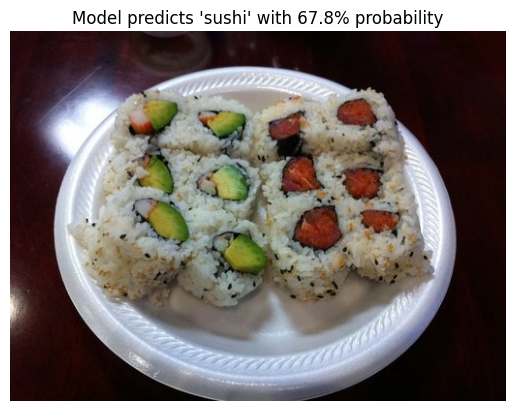

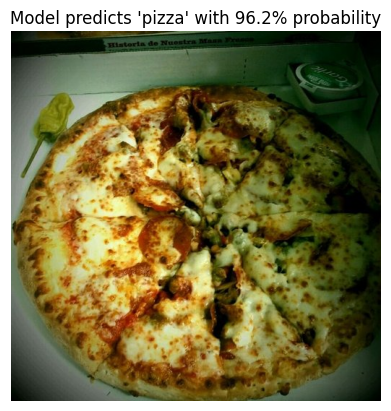

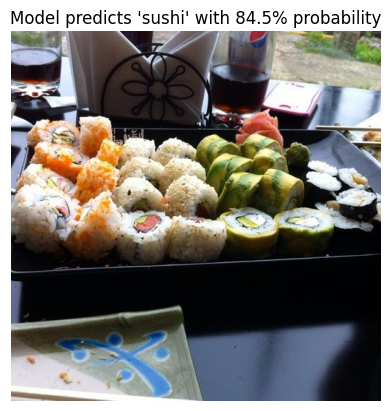

In [13]:
import random
num_images = 10
image_path_list = list(Path(test_dir).glob("*/*.jpg"))
image_random_sample = random.sample(population=image_path_list, k=num_images)

for image_path in image_random_sample:
    pred_and_plot_image(
        model=model,
        image_path=image_path,
        class_names=class_names,
        image_size=(224, 224)
    )

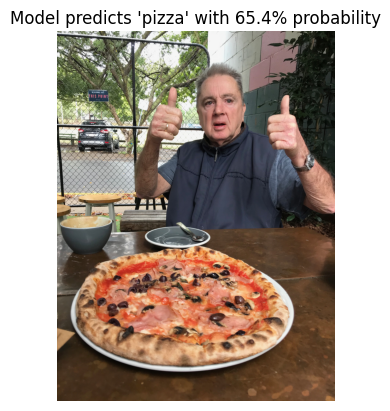

In [15]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        f.write(request.content)

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)